# 1. Dependencies

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data Preprocessing

In [ ]:
df = pd.read_stata('/content/drive/MyDrive/SNU_Fintech/SNU - 5조/Lending Club/lendingclub.dta')

In [ ]:
df.shape

(1092919, 333)

In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,...,mths_since_recent_bc4,mths_since_recent_bc5,mths_since_recent_bc6,mths_since_recent_bc7,mths_since_recent_bc8,mths_since_recent_bc9,mths_since_recent_bc10,mths_since_recent_bc11,mths_since_recent_bc_dlq1,mths_since_recent_bc_dlq2,mths_since_recent_bc_dlq3,mths_since_recent_bc_dlq4,mths_since_recent_bc_dlq5,mths_since_recent_bc_dlq6,mths_since_recent_bc_dlq7,mths_since_recent_bc_dlq8,mths_since_recent_bc_dlq9,mths_since_recent_bc_dlq10,mths_since_recent_bc_dlq11,mths_since_recent_inq1,mths_since_recent_inq2,mths_since_recent_inq3,mths_since_recent_inq4,mths_since_recent_inq5,mths_since_recent_inq6,mths_since_recent_inq7,mths_since_recent_inq8,mths_since_recent_inq9,mths_since_recent_inq10,mths_since_recent_revol_delinq1,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
0,19000,19000,19000.0,0.0916,605.62,65000.0,16.36,1,670,674,0,10,0,10644,0.714,27,0.0,0.0,20635.862570,20635.86,19000.00,1635.86,0.0,0.0,0.0,13387.76,734,730,0,0,0,33375,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,10000,10000,10000.0,0.0789,312.86,58000.0,5.03,0,690,694,1,5,0,7940,0.684,6,0.0,0.0,10185.630000,10185.63,10000.00,185.63,0.0,0.0,0.0,9568.68,694,690,0,0,0,151309,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,6000,6000,6000.0,0.1147,197.78,46900.0,24.23,2,665,669,1,9,0,4161,0.257,14,0.0,0.0,7112.021631,7112.02,6000.00,1112.02,0.0,0.0,0.0,197.37,579,575,0,0,0,19337,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,25200,25200,25200.0,0.1199,836.89,76280.0,32.87,0,685,689,0,5,1,7755,0.566,34,0.0,0.0,16704.230000,16704.23,12882.27,3821.96,0.0,0.0,0.0,836.89,564,560,0,0,0,59295,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,8000,8000,8000.0,0.1299,269.52,29000.0,20.28,0,770,774,1,12,0,6324,0.160,15,0.0,0.0,9627.310205,9627.31,8000.00,1627.31,0.0,0.0,0.0,1831.86,684,680,0,0,0,29418,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


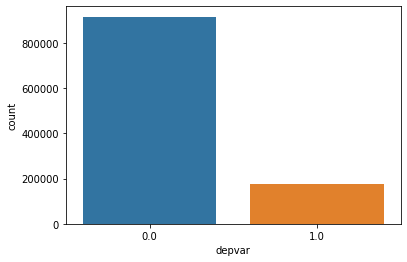

In [ ]:
sns.countplot(x= 'depvar', data = df)

In [ ]:
# 대출 해주는 시점에서 관측 불가능한 변수와 관측 가능한 변수 구분
post_attr = ['out_prncp','out_prncp_inv', 'total_pymnt','total_pymnt_inv', 'total_rec_prncp','total_rec_int',  
'recoveries', 'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_amnt', 'debt_settlement_flag1',
'installment','elapsed_t','term1']

for i in range(1,119):
    col = 'issue_d' + str(i)
    post_attr.append(col)

cat_lists = ['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record',
             'mths_since_rcnt_il','mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_revol_delinq']

for col in cat_lists:
    for i in range(1,12):
        coli = col + str(i)
        post_attr.append(coli)
        
for i in range(1,11):
    col = 'mths_since_recent_inq' + str(i)
    post_attr.append(col)

In [ ]:
pre_attr = list(set(df.columns) - set(post_attr))
pre_attr.sort()

In [ ]:
df = df[pre_attr]
df.shape

(1092919, 114)

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=47)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.25,random_state=73)

list = {a,b,c,d}
enmuerate(list)
 = (0,a) (1,b) (2,c) (3,d)

### confusion matrix & ploting confusion matirx

In [ ]:
def fis(a,b):
    c = a+b
    return c
result =fis(1,100) 
print(result)

101


In [ ]:
# confusion matrix : fpr, tpr 계산하기
def get_rates(cm):
    
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    TN = cm[0,0]

    Recall = TP / (TP + FN) # Sensitivity, hit rate, recall, or true positive rate
    Precision = TP / (TP + FP) # Precision or positive predictive value
    FPR = FP / (FP + TN) # False positive rate or False alarm rate
    # FNR = FN / (FN + TP) # False negative rate or Miss Rate
    Accuracy = (TP+TN) / (FP+FN+TP+TN)

    return Recall, FPR, Precision, Accuracy



# plotting confusion matrix
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    sns.set(rc={'figure.figsize':(10,9)})
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 3. Logistic Regression

* Feature Selectoin : DecisionTree / Lasso 

## I) Feature Selection : Decision Tree

In [ ]:
dt_model.predict_proba(X_train)

array([[0.14194229, 0.85805771],
       [0.59237509, 0.40762491],
       [0.60964225, 0.39035775],
       ...,
       [0.98786131, 0.01213869],
       [0.97351825, 0.02648175],
       [0.98808691, 0.01191309]])

In [ ]:
dt_model = DecisionTreeClassifier(random_state=43, criterion='entropy',max_depth=10,class_weight='balanced')
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=43, splitter='best')

In [ ]:
fi_col1 = []
fi1 = []

for i, column in enumerate(X):
  fi_col1.append(column)
  fi1.append(dt_model.feature_importances_[i])

fi_df1 = pd.DataFrame(zip(fi_col1, fi1), columns=['features', 'feature importance'])
fi_df1 = fi_df1.sort_values('feature importance', ascending=False).reset_index()
idx_to_drop = fi_df1.index[fi_df1['feature importance'] == 0].tolist()
fi_df1.drop(index = idx_to_drop,inplace=True) # feature importance 가 0인 변수들 제거
print(fi_df1.shape) # 114개중에 75개 살아남음
fi_df1.head()

(75, 3)


,index,features,feature importance
0,85,last_fico_range_low,0.906617
1,84,last_fico_range_high,0.021945
2,72,funded_amnt,0.010985
3,83,int_rate,0.009709
4,61,emp_length12,0.007586


In [ ]:
X_train_dt = X_train[fi_df1.features]
X_valid_dt = X_valid[fi_df1.features]
X_test_dt = X_test[fi_df1.features]

print(X_train_dt.shape)
print(X_valid_dt.shape)
print(X_test_dt.shape)

(655751, 75)
(218584, 75)
(218584, 75)


In [ ]:
w = {0:1, 1:4.5}
log_reg_dt = LogisticRegression(random_state=37, solver='saga', class_weight=w)
log_reg_dt.fit(X_train_dt, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight={0: 1, 1: 4.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=37, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.165714 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.165714 to fit



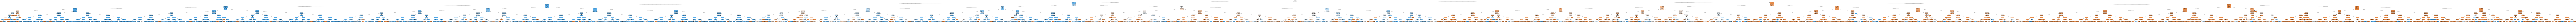

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [ ]:
y_pred_dt = log_reg_dt.predict(X_train_dt)
pred_prob_dt = log_reg_dt.predict_proba(X_train_dt)
log_reg_dt.coef_
print("Predicted classes for train set are:{}".format(y_pred_dt) , "The coefficients are : {}".format(log_reg_dt.coef_), "Odds are:{}".format(np.exp(log_reg_dt.coef_)), sep='\n')


Predicted classes for train set are:[1. 0. 0. ... 1. 1. 0.]
The coefficients are : [[-2.44730077e-06 -1.73248571e-06  6.84953086e-06  3.40318346e-10
   3.06152535e-10  6.84704819e-06  6.89016290e-09  2.41630956e-08
  -3.44864293e-06  4.48148568e-10 -1.22084942e-06 -9.87654904e-07
  -1.13888796e-07  6.84930541e-06 -1.13816410e-07  7.46618838e-09
   2.08211372e-07  5.24864760e-10  6.85065192e-10  2.71921385e-09
   2.90217266e-10  8.88722885e-10 -5.32209537e-10  5.50646884e-10
   3.17036775e-10 -8.27527027e-11  1.06448260e-10 -1.16050280e-09
  -3.11001363e-10 -5.29828123e-10 -3.09724333e-11 -3.13486487e-11
   2.30594606e-11 -1.90949850e-11 -6.07657706e-10  1.52601976e-07
  -5.73015471e-11  1.70933373e-11 -2.25217368e-11  6.50682310e-11
   4.71864514e-10  1.29800809e-10 -5.40929642e-12 -3.68125870e-11
   2.26475501e-11  2.14935186e-11  1.17312406e-12  3.57614747e-12
   1.02530365e-11 -3.05993992e-11  2.37821420e-11 -1.33536003e-11
   2.44941563e-11  6.11112165e-13  1.33173346e-11  1.129872

In [ ]:
pred_prob_dt

array([[0.49306553, 0.50693447],
       [0.52359952, 0.47640048],
       [0.60452695, 0.39547305],
       ...,
       [0.45921001, 0.54078999],
       [0.45360437, 0.54639563],
       [0.52643221, 0.47356779]])

In [ ]:
print("Train accuracy is: ", log_reg_dt.score(X_train_dt, y_train))
print("Test accuracy is: ", log_reg_dt.score(X_test_dt, y_test))
print(classification_report(y_train, y_pred_dt))

Train accuracy is:  0.6793249266871114
Test accuracy is:  0.6798484793031512
              precision    recall  f1-score   support

         0.0       0.86      0.74      0.79    549698
         1.0       0.22      0.38      0.28    106053

    accuracy                           0.68    655751
   macro avg       0.54      0.56      0.53    655751
weighted avg       0.76      0.68      0.71    655751



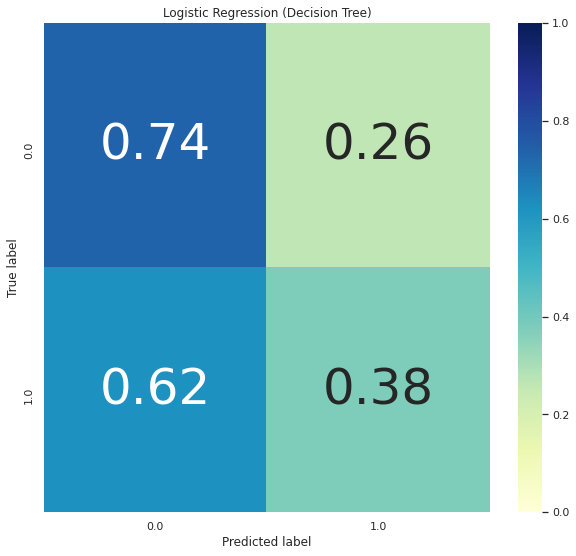

In [ ]:
cm = confusion_matrix(y_train, y_pred_dt)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg_dt.classes_, title='Logistic Regression (Decision Tree)')

In [ ]:
print(cm, cm_norm, sep='\n\n\n')

[[405403 144295]
 [ 65988  40065]]


[[0.73750132 0.26249868]
 [0.62221719 0.37778281]]


In [ ]:
pred_proba_valid = log_reg_dt.predict_proba(X_valid_dt)
fpr, tpr, thresholds = roc_curve(y_valid,pred_proba_valid[:,1])
roc_auc_logit = auc(fpr, tpr)
roc_auc_logit

0.5878683787178327

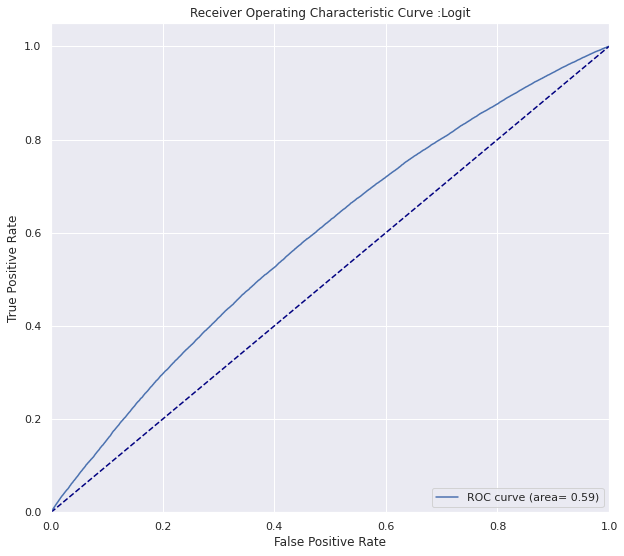

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc_logit)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# finding optimal threshold
for i in threshold_interval:
    valid_result_temp0 = pd.DataFrame(log_reg_dt.predict_proba(X_valid_dt)[:,1],columns=['pred_prob'])
    valid_result_temp0['binary'] = np.where(valid_result_temp0['pred_prob']>=(i-0.01),1,0)

    valid_result_temp1 = pd.DataFrame(log_reg_dt.predict_proba(X_valid_dt)[:,1],columns=['pred_prob'])
    valid_result_temp1['binary'] = np.where(valid_result_temp1['pred_prob']>=i,1,0)
    
    cm_temp0 = confusion_matrix(y_test,valid_result_temp0['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    cm_temp1 = confusion_matrix(y_test,valid_result_temp1['binary'])
    cm_norm_temp1 = cm_temp1 / cm_temp1.sum(axis=1).reshape(-1,1)
    # print("1-fpr : tpr = {} : {}".format(a*5/100,1-(a*5/100)))
    # print("optimal threshold : {}".format(np.ceil(optimal_threshold_logit_temp*1000)/1000))
    print(i)
    print(-4.5*12*(cm_norm_temp1[0,1]-cm_norm_temp0[0,1])>33*(cm_norm_temp1[1,0]-cm_norm_temp0[1,0]))
    print("accuracy is :", (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1]))
    print('')

0.0
False
accuracy is : 0.1615488782344545

0.01
True
accuracy is : 0.1617410240456758

0.02
True
accuracy is : 0.16182337225048493

0.03
True
accuracy is : 0.16190572045529408

0.04
False
accuracy is : 0.16198349375983603

0.05
True
accuracy is : 0.16208414156571388

0.06
True
accuracy is : 0.16220766387292757

0.07
False
accuracy is : 0.1622945869780039

0.08
True
accuracy is : 0.1624318339860191

0.09
True
accuracy is : 0.16264685429857628

0.1
True
accuracy is : 0.16280697580792738

0.11
True
accuracy is : 0.1629670973172785

0.12
True
accuracy is : 0.16315466822823263

0.13
True
accuracy is : 0.16336968854078981

0.14
True
accuracy is : 0.16360758335468287

0.15
True
accuracy is : 0.16394612597445377

0.16
True
accuracy is : 0.1643487171979651

0.17
True
accuracy is : 0.16472843392014055

0.18
True
accuracy is : 0.16513560004391906

0.19
True
accuracy is : 0.16555649086849908

0.2
True
accuracy is : 0.1662061267064378

0.21
True
accuracy is : 0.16680086374117045

0.22
True
accurac

* optimal_threshold_df_lg = 0.62
* accuracy : 0.8384465468652783

In [ ]:
optimal_threshold_df_lg = 0.62

# test set 검증
test_result_lg1 = pd.DataFrame(log_reg_dt.predict_proba(X_test_dt)[:,1],columns=['pred_prob'])
test_result_lg1['dt_binary'] = np.where(test_result_lg1['pred_prob']>=optimal_threshold_df_lg,1,0)

In [ ]:
test_result_lg1

,pred_prob,dt_binary
0,0.529090,0
1,0.499169,0
2,0.495492,0
3,0.568262,0
4,0.521806,0
...,...,...
218579,0.434723,0
218580,0.471269,0
218581,0.450444,0
218582,0.411573,0


In [ ]:
cm2 = confusion_matrix(y_test,test_result_lg1['dt_binary'])
cm2

array([[183271,      1],
       [ 35312,      0]])

In [ ]:
print(classification_report(y_test, test_result_lg1['dt_binary']))

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183272
         1.0       0.00      0.00      0.00     35312

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
tpr, fpr, prc, acc =  get_rates(cm2)
print("TPR : {:.2f}%".format(tpr*100))
print("FPR : {:.2f}%".format(fpr*100))
print("Precision : {:.2f}%".format(prc*100))
print("Accuracy : {:.2f}%".format(acc*100))

TPR : 0.00%
FPR : 0.00%
Precision : 0.00%
Accuracy : 83.84%


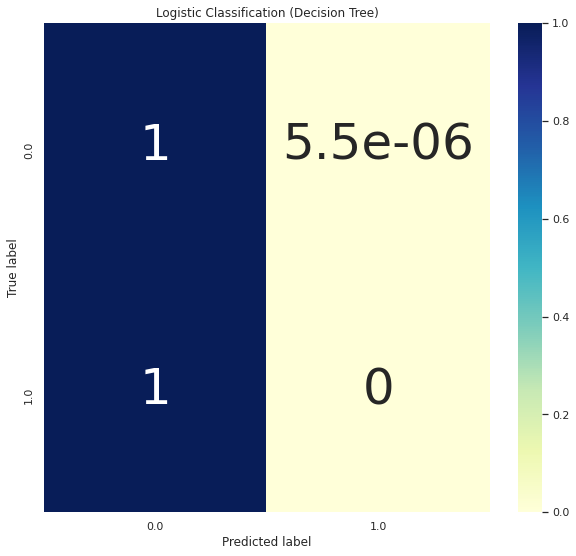

In [ ]:
cm2_norm = cm2 / cm2.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm2_norm, classes = log_reg_dt.classes_, title='Logistic Classification (Decision Tree)')

## II) Featuer Selection : Lasso

In [ ]:
w = {0:1, 1:4.5}
log_reg_ls = LogisticRegression(penalty = 'l1',random_state=37, solver='saga', class_weight=w, C=0.001)
log_reg_ls.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0005, class_weight={0: 1, 1: 4.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=37, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# 살아남은 변수 확인하기
fi_col4 = []
fi4 = []

for i, column in enumerate(X):
  fi_col4.append(column)
  fi4.append(log_reg_ls.coef_[0][i])

fi_df4 = zip(fi_col4, fi4)
fi_df4 = pd.DataFrame(fi_df4, columns=['features', 'feature importance'])
fi_df4 = fi_df4.sort_values('feature importance', ascending=False).reset_index()

idx_to_drop3 = fi_df4.index[fi_df4['feature importance'] == 0].tolist()
fi_df4.drop(index = idx_to_drop3,inplace=True) # feature importance 가 0인 변수들 제거
print(fi_df4.shape) # 113개중에 41개 살아남음 
fi_df4.iloc[:,1:].head()

(41, 3)


,features,feature importance
0,funded_amnt,6.849508e-06
1,loan_amnt,6.849282e-06
2,funded_amnt_inv,6.847025e-06
3,tot_coll_amt,2.081605e-07
4,delinq_amnt,1.525486e-07


In [ ]:
y_pred_ls = log_reg_ls.predict(X_train)
pred_prob_ls = log_reg_ls.predict_proba(X_train)
log_reg_ls.coef_
print("Predicted classes for train set are:{}".format(y_pred_ls) , "The coefficients are : {}".format(log_reg_ls.coef_), "Odds are:{}".format(np.exp(log_reg_ls.coef_)), sep='\n')

Predicted classes for train set are:[1. 0. 0. ... 1. 1. 0.]
The coefficients are : [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.44862611e-06  0.00000000e+00  0.00000000e+00  5.775935

In [ ]:
pred_prob_ls

array([[0.49306557, 0.50693443],
       [0.52359933, 0.47640067],
       [0.60452908, 0.39547092],
       ...,
       [0.4592102 , 0.5407898 ],
       [0.45360479, 0.54639521],
       [0.52643211, 0.47356789]])

In [ ]:
print("Train accuracy is: ", log_reg_ls.score(X_train, y_train))
print("Test accuracy is: ", log_reg_ls.score(X_test, y_test))
print(classification_report(y_train, y_pred_ls))

Train accuracy is:  0.6793249266871114
Test accuracy is:  0.6798484793031512
              precision    recall  f1-score   support

         0.0       0.86      0.74      0.79    549698
         1.0       0.22      0.38      0.28    106053

    accuracy                           0.68    655751
   macro avg       0.54      0.56      0.53    655751
weighted avg       0.76      0.68      0.71    655751



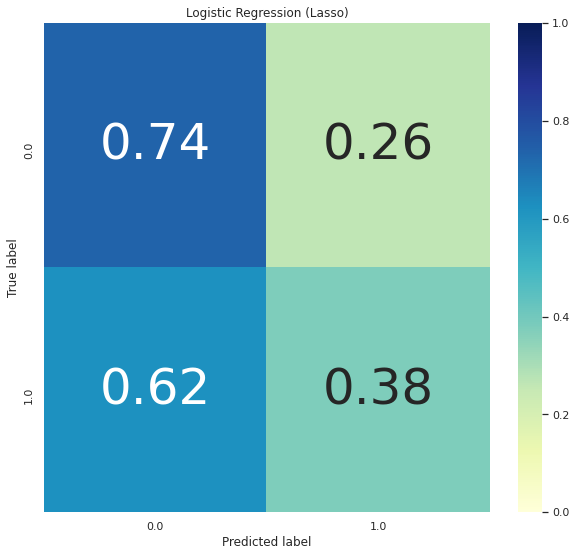

In [ ]:
cm = confusion_matrix(y_train, y_pred_ls)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg_ls.classes_, title='Logistic Regression (Lasso)')

In [ ]:
print(cm, cm_norm, sep='\n\n\n')

[[405403 144295]
 [ 65988  40065]]


[[0.73750132 0.26249868]
 [0.62221719 0.37778281]]


In [ ]:
pred_proba_valid = log_reg_ls.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid,pred_proba_valid[:,1])
roc_auc_logit = auc(fpr, tpr)
roc_auc_logit

0.5878682619844464

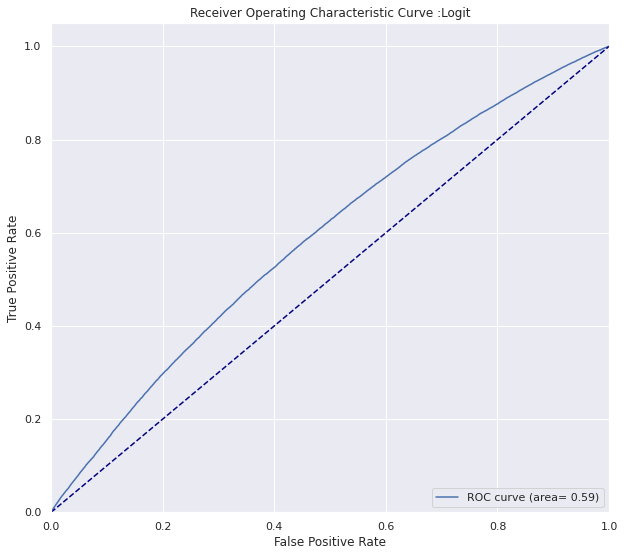

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc_logit)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# finding optimal threshold
threshold_interval = np.linspace(0,1,101)

for i in threshold_interval:
    valid_result_temp0 = pd.DataFrame(log_reg_ls.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp0['binary'] = np.where(valid_result_temp0['pred_prob']>=(i-0.01),1,0)

    valid_result_temp1 = pd.DataFrame(log_reg_ls.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp1['binary'] = np.where(valid_result_temp1['pred_prob']>=i,1,0)
    
    cm_temp0 = confusion_matrix(y_test,valid_result_temp0['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    cm_temp1 = confusion_matrix(y_test,valid_result_temp1['binary'])
    cm_norm_temp1 = cm_temp1 / cm_temp1.sum(axis=1).reshape(-1,1)
    
    # print("1-fpr : tpr = {} : {}".format(a*5/100,1-(a*5/100)))
    # print("optimal threshold : {}".format(np.ceil(optimal_threshold_logit_temp*1000)/1000))
    print(i)
    print(-4.5*12*(cm_norm_temp1[0,1]-cm_norm_temp0[0,1])>33*(cm_norm_temp1[1,0]-cm_norm_temp0[1,0]))
    print("accuracy is :", (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1]))
    print('')

0.0
False
accuracy is : 0.1615488782344545

0.01
True
accuracy is : 0.1617410240456758

0.02
True
accuracy is : 0.16182337225048493

0.03
True
accuracy is : 0.16190572045529408

0.04
False
accuracy is : 0.16198349375983603

0.05
True
accuracy is : 0.16208414156571388

0.06
True
accuracy is : 0.16220766387292757

0.07
False
accuracy is : 0.1622945869780039

0.08
True
accuracy is : 0.1624318339860191

0.09
True
accuracy is : 0.16264685429857628

0.1
True
accuracy is : 0.16280697580792738

0.11
True
accuracy is : 0.1629670973172785

0.12
True
accuracy is : 0.16315466822823263

0.13
True
accuracy is : 0.16336968854078981

0.14
True
accuracy is : 0.16360758335468287

0.15
True
accuracy is : 0.16394612597445377

0.16
True
accuracy is : 0.1643487171979651

0.17
True
accuracy is : 0.16472843392014055

0.18
True
accuracy is : 0.16513560004391906

0.19
True
accuracy is : 0.16555649086849908

0.2
True
accuracy is : 0.1662061267064378

0.21
True
accuracy is : 0.16680086374117045

0.22
True
accurac

* optimal_threshold_ls_lg = 0.62
* accuracy : 0.8384465468652783

In [ ]:
optimal_threshold_ls_lg = 0.62

# test set 검증
test_result_lg2 = pd.DataFrame(log_reg_ls.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result_lg2['ls_binary'] = np.where(test_result_lg2['pred_prob']>=optimal_threshold_ls_lg,1,0)

In [ ]:
test_result_lg2

,pred_prob,ls_binary
0,0.529089,0
1,0.499169,0
2,0.495492,0
3,0.568261,0
4,0.521806,0
...,...,...
218579,0.434723,0
218580,0.471269,0
218581,0.450444,0
218582,0.411573,0


In [ ]:
cm2 = confusion_matrix(y_test,test_result_lg2['ls_binary'])
cm2

array([[183271,      1],
       [ 35312,      0]])

In [ ]:
print(classification_report(y_test, test_result_lg2['ls_binary']))

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183272
         1.0       0.00      0.00      0.00     35312

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
tpr, fpr, prc, acc =  get_rates(cm2)
print("TPR : {:.2f}%".format(tpr*100))
print("FPR : {:.2f}%".format(fpr*100))
print("Precision : {:.2f}%".format(prc*100))
print("Accuracy : {:.2f}%".format(acc*100))

TPR : 0.00%
FPR : 0.00%
Precision : 0.00%
Accuracy : 83.84%


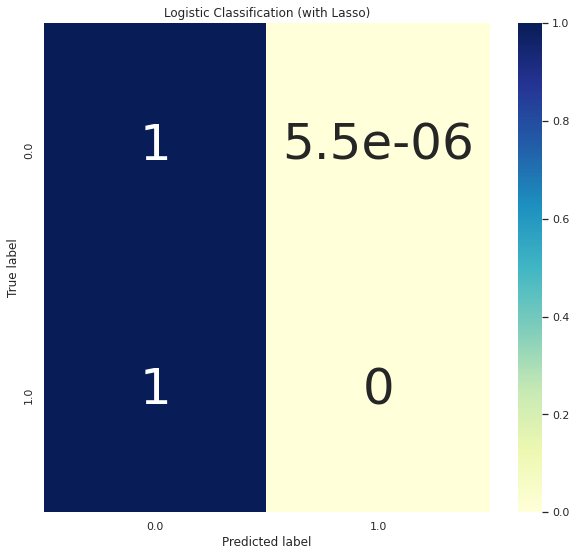

In [ ]:
cm2_norm = cm2 / cm2.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm2_norm, classes = log_reg_ls.classes_, title='Logistic Classification (with Lasso)')

# 4. Random Forest Classifier

In [ ]:
# w = {0:1,1:9}
rf_model = RandomForestClassifier(class_weight='balanced',criterion='entropy',max_depth=7,random_state=47)
rf_model.fit(X=X_train, y=y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=47, verbose=0,
                       warm_start=False)

In [ ]:
fi_col2 = []
fi2 = []

for i, column in enumerate(X):
  fi_col2.append(column)
  fi2.append(rf_model.feature_importances_[i])

fi_df2 = zip(fi_col2, fi2)
fi_df2 = pd.DataFrame(fi_df2, columns=['features', 'feature importance'])
fi_df2 = fi_df2.sort_values('feature importance', ascending=False).reset_index()

idx_to_drop2 = fi_df2.index[fi_df2['feature importance'] == 0].tolist()
fi_df2.drop(index = idx_to_drop2,inplace=True) # feature importance 가 0인 변수들 제거
print(fi_df2.shape) # 113개 중에 111개 생존
fi_df2.head()

(111, 3)


,index,features,feature importance
0,84,last_fico_range_high,0.446779
1,85,last_fico_range_low,0.438049
2,83,int_rate,0.046423
3,70,fico_range_high,0.011368
4,71,fico_range_low,0.010357


In [ ]:
valid_pred2 = rf_model.predict(X_valid)
valid_pred_prob2 = rf_model.predict_proba(X_valid) # 각 column : 0(살아날)일 확률 & 1(부도할) 확률

In [ ]:
# roc_curve & auc
fpr, tpr, threshold = roc_curve(y_valid,valid_pred_prob2[:,1])
roc_auc = auc(fpr,tpr)
roc_auc

0.917858852511197

In [ ]:
roc_result = pd.DataFrame([fpr,tpr,threshold], index=['fpr','tpr','threshold']).T
roc_result['best'] = (1-roc_result['fpr'])+(roc_result['tpr'])
roc_result.head()

,fpr,tpr,threshold,best
0,0.000000,0.000000,1.847388,1.000000
1,0.000000,0.000028,0.847388,1.000028
2,0.000000,0.000085,0.844473,1.000085
3,0.000011,0.000085,0.843617,1.000074
4,0.000011,0.000479,0.840990,1.000469


In [ ]:
bayesian_threshold=roc_result.threshold[roc_result.best.idxmax()]
bayesian_threshold

0.5935527140138795

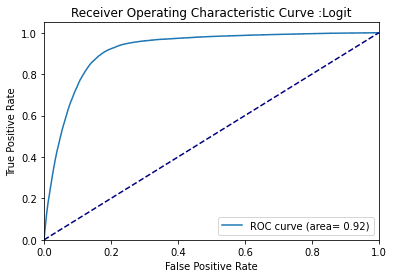

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [ ]:
threshold_interval = np.linspace(0,1,101)

for i in threshold_interval:
    test_result_temp0 = pd.DataFrame(rf_model.predict_proba(X_test)[:,1],columns=['pred_prob'])
    test_result_temp0['binary'] = np.where(test_result_temp0['pred_prob']>=(i-0.01),1,0)

    test_result_temp1 = pd.DataFrame(rf_model.predict_proba(X_test)[:,1],columns=['pred_prob'])
    test_result_temp1['binary'] = np.where(test_result_temp1['pred_prob']>=i,1,0)
    
    cm_temp0 = confusion_matrix(y_test,test_result_temp0['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    cm_temp1 = confusion_matrix(y_test,test_result_temp1['binary'])
    cm_norm_temp1 = cm_temp1 / cm_temp1.sum(axis=1).reshape(-1,1)
    # print("1-fpr : tpr = {} : {}".format(a*5/100,1-(a*5/100)))
    # print("optimal threshold : {}".format(np.ceil(optimal_threshold_logit_temp*1000)/1000))
    print(i)
    print(-4.5*12*(cm_norm_temp1[0,1]-cm_norm_temp0[0,1])>33*(cm_norm_temp1[1,0]-cm_norm_temp0[1,0]))
    print("accuracy is :", (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1]))
    print('')

0.0
False
accuracy is : 0.1615488782344545

0.01
False
accuracy is : 0.1615488782344545

0.02
False
accuracy is : 0.1615488782344545

0.03
False
accuracy is : 0.1615488782344545

0.04
False
accuracy is : 0.1615488782344545

0.05
False
accuracy is : 0.1615488782344545

0.06
False
accuracy is : 0.1615488782344545

0.07
True
accuracy is : 0.16155802803498884

0.08
True
accuracy is : 0.1624638582878893

0.09
True
accuracy is : 0.16699758445265894

0.1
True
accuracy is : 0.17537880174212203

0.11
True
accuracy is : 0.19122168136734619

0.12
True
accuracy is : 0.21634703363466676

0.13
True
accuracy is : 0.24933663946125975

0.14
True
accuracy is : 0.28880430406617136

0.15
True
accuracy is : 0.331108406836731

0.16
True
accuracy is : 0.3753248179189694

0.17
True
accuracy is : 0.41886871866193315

0.18
True
accuracy is : 0.4624263441056985

0.19
True
accuracy is : 0.5047304468762581

0.2
True
accuracy is : 0.5462613915016653

0.21
True
accuracy is : 0.5877374373238663

0.22
True
accuracy is

* optimal_threshold_rf = 0.65
* accuracy : 0.8581735168173333

In [ ]:
optimal_threshold_rf = 0.65

# test set 검증
test_result2 = pd.DataFrame(rf_model.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result2['rf_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_rf,1,0)

In [ ]:
test_result2

,pred_prob,rf_binary
0,0.217246,0
1,0.219718,0
2,0.205562,0
3,0.207409,0
4,0.775758,1
...,...,...
218579,0.606615,0
218580,0.141176,0
218581,0.765723,1
218582,0.213117,0


In [ ]:
cm2 = confusion_matrix(y_test,test_result2['rf_binary'])
cm2

array([[157390,  25882],
       [  5119,  30193]])

In [ ]:
print(classification_report(y_test, test_result2['rf_binary']))

              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91    183272
         1.0       0.54      0.86      0.66     35312

    accuracy                           0.86    218584
   macro avg       0.75      0.86      0.79    218584
weighted avg       0.90      0.86      0.87    218584



In [ ]:
tpr, fpr, prc, acc =  get_rates(cm2)
print("TPR : {:.2f}%".format(tpr*100))
print("FPR : {:.2f}%".format(fpr*100))
print("Precision : {:.2f}%".format(prc*100))
print("Accuracy : {:.2f}%".format(acc*100))

TPR : 85.50%
FPR : 14.12%
Precision : 53.84%
Accuracy : 85.82%


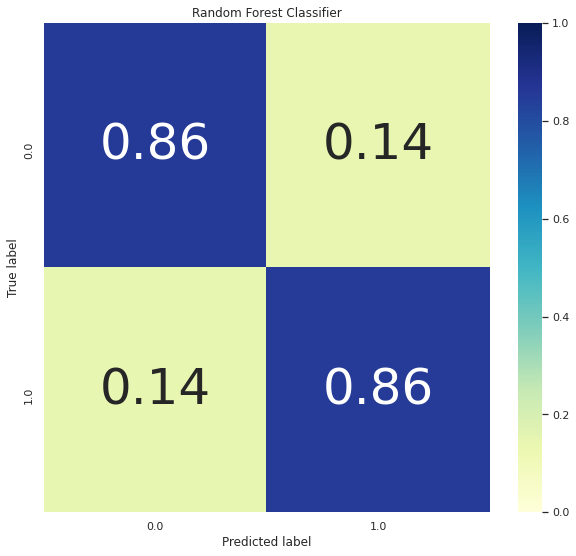

In [ ]:
cm2_norm = cm2 / cm2.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm2_norm, classes = rf_model.classes_, title='Random Forest Classifier')